# Fraud Detection using Graph Models
Made by Nikolai Suanov and Roman Khamrin

# Abstract

This dataframe represents the syntetic-generated bank transactions of a spanish bank.

It contains the following columns:
* step - a day of commercial activity.
* customer - id of the customer
* age - age of the customer
* gender - gender of the customer
* zipcodeOri - zip code of buyer
* merchant - id of merchant
* zipMerchant - zip code of merchant
* category - category of the good
* amount - amount of the good sold
* fraud - is transaction fraudlent or not

The data frame is built for academic research purposes based on the concept of Multi Agent-Based Simulation.

# Problem

The financial sector and banking especially have suffered increase in fraudulent activities. This states a major problem because such transactions lead to both financial losses and lack of trust to financial institutes. Also banks a should obey the law and find such transactions due to their license agreement (for example, 115-ФЗ).

The complexity of this schemes raises, that is why now every large bank uses non-human methods of automatic detection of such activity. The **object** of this research is to develop the algorithm to detect fraudlent transactions. The **subject** is the synthetic data about bank transactions. The **main steps** of research is to:
1. Make a EDA to understand the data
2. Add graph features to the data set
3. Preprocess data before creating model
4. Train different models to and get first results
5. Add SMOTE resampling to the data set in order to increase score
6. Tune the best model to get the final results



# Imports and data reading

In [1]:
# main
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

# graphs
import networkx as nx
import community as community_louvain # import this for google colab
# import community.community_louvain as community_louvain # import this for VSCode and etc

# preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# ML
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score
from sklearn import metrics

import pickle

from sklearn.model_selection import GridSearchCV

# warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# connect to google drive to access data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# read data
# banks = pd.read_csv('/content/gdrive/MyDrive/SNA/bs140513_032310.csv') # read in colab
banks = pd.read_csv('bs140513_032310.csv')
banks.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


# EDA

In [3]:
# general description of the data
banks.describe()

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


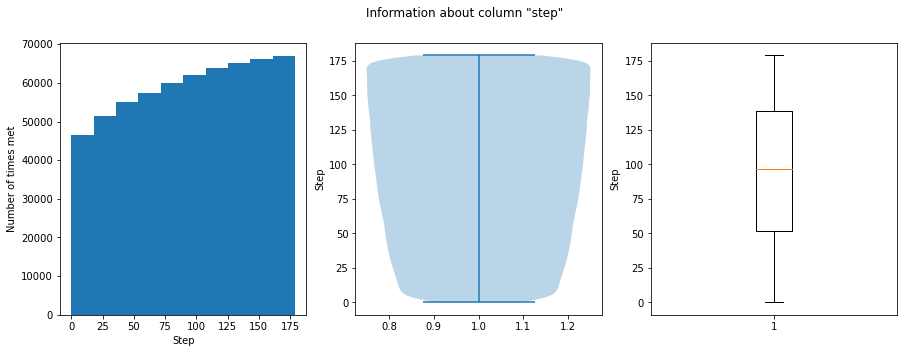

In [4]:
# information about columns 'step'
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plt.suptitle('Information about column "step"')
axes[0].hist(
    banks['step']
)

axes[0].set_xlabel('Step')
axes[0].set_ylabel('Number of times met')

axes[1].violinplot(
    banks['step']
)
axes[1].set_ylabel('Step')

axes[2].boxplot(
    banks['step']
)
axes[2].set_ylabel('Step')

plt.show()

<Figure size 1080x360 with 0 Axes>

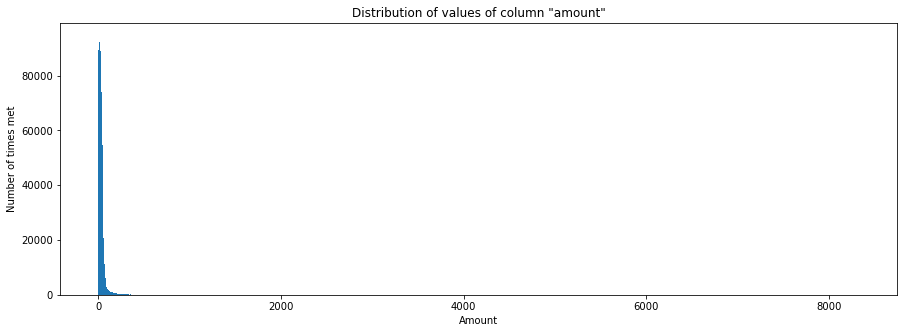

In [5]:
plt.figure(figsize=(15, 5))

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

plt.hist(
    banks['amount'],
    bins = 1000
)
plt.xlabel('Amount')
plt.ylabel('Number of times met')
plt.title('Distribution of values of column "amount"')
plt.show()

Text(0.5, 1.0, 'Distribution of values of column "Age"')

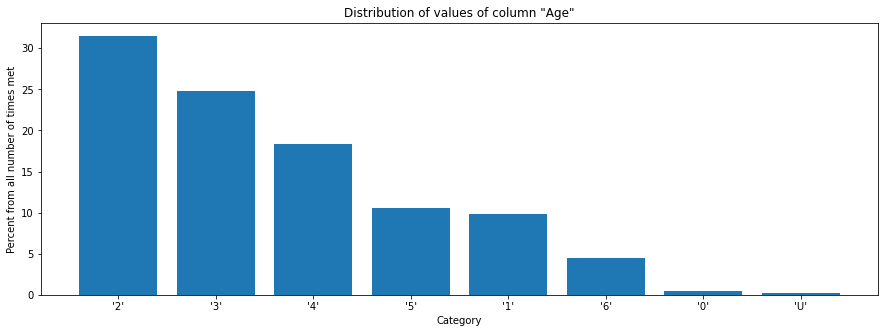

In [6]:
plt.figure(figsize=(15, 5))

plt.bar(
    banks['age'].value_counts().reset_index()['index'],
    banks['age'].value_counts().reset_index()['age'] * 100 / np.sum(
        banks['age'].value_counts().reset_index()['age']
    ),
)

plt.xlabel('Category')
plt.ylabel('Percent from all number of times met')
plt.title('Distribution of values of column "Age"')

Text(0.5, 1.0, 'Distribution of values of column "category"')

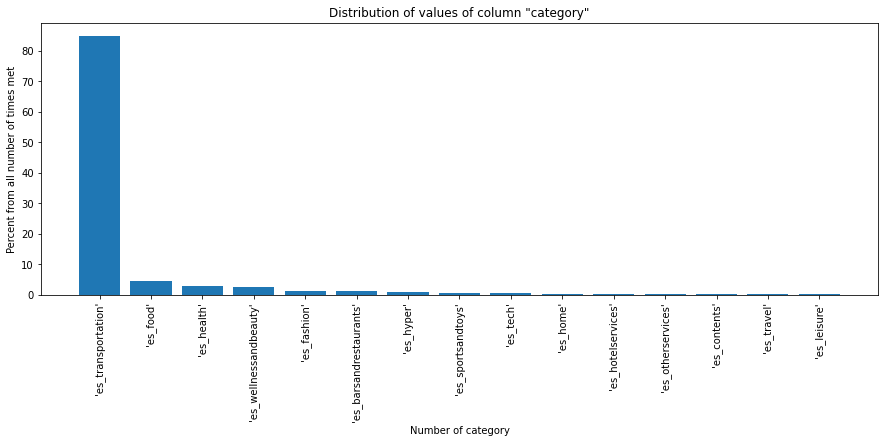

In [7]:
plt.figure(figsize=(15, 5))

plt.bar(
    banks['category'].value_counts().reset_index()['index'],
    banks['category'].value_counts().reset_index()['category'] *100/ np.sum(
        banks['category'].value_counts().reset_index()['category']
    ),
)

plt.xlabel('Number of category')
plt.ylabel('Percent from all number of times met')
plt.xticks(rotation=90)
plt.title('Distribution of values of column "category"')

Text(0.5, 1.0, 'Distribution of values of column "gender"')

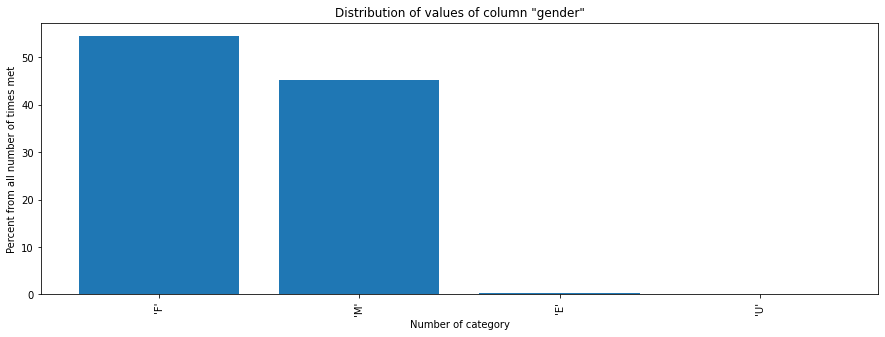

In [8]:
plt.figure(figsize=(15, 5))

plt.bar(
    banks['gender'].value_counts().reset_index()['index'],
    banks['gender'].value_counts().reset_index()['gender'] *100/ np.sum(
        banks['gender'].value_counts().reset_index()['gender']
    ),
)

plt.xlabel('Number of category')
plt.ylabel('Percent from all number of times met')
plt.xticks(rotation=90)
plt.title('Distribution of values of column "gender"')

Text(0.5, 1.0, 'Distribution of top-20 customers')

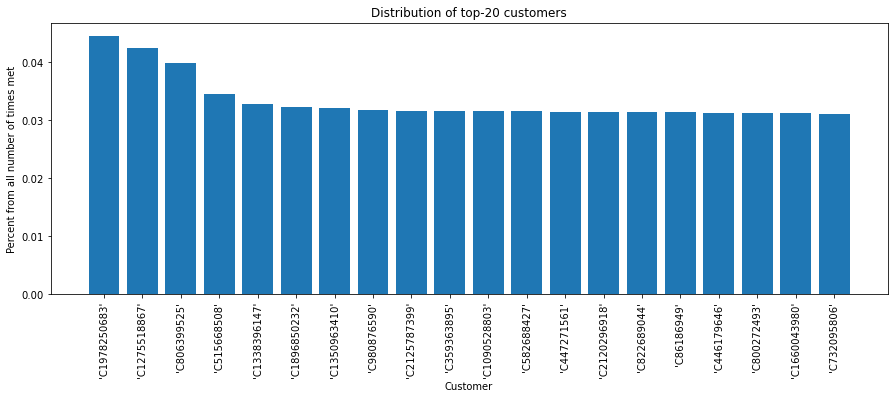

In [9]:
plt.figure(figsize=(15, 5))

plt.bar(
    banks['customer'].value_counts().reset_index()['index'][:20],
    banks['customer'].value_counts().reset_index()['customer'][:20] *100/ np.sum(
        banks['customer'].value_counts().reset_index()['customer']
    ),
)

plt.xlabel('Customer')
plt.ylabel('Percent from all number of times met')
plt.xticks(rotation=90)
plt.title('Distribution of top-20 customers')

Text(0.5, 1.0, 'Distribution of top-20 merchant')

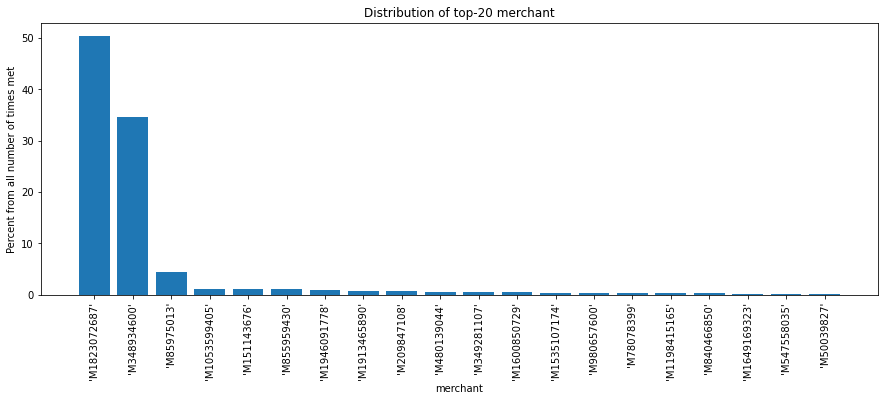

In [10]:
plt.figure(figsize=(15, 5))

plt.bar(
    banks['merchant'].value_counts().reset_index()['index'][:20],
    banks['merchant'].value_counts().reset_index()['merchant'][:20] *100/ np.sum(
        banks['merchant'].value_counts().reset_index()['merchant']
    ),
)

plt.xlabel('merchant')
plt.ylabel('Percent from all number of times met')
plt.xticks(rotation=90)
plt.title('Distribution of top-20 merchant')

Percent of fraudlent transactions: 
0    98.789189
1     1.210811
Name: fraud, dtype: float64%.2f


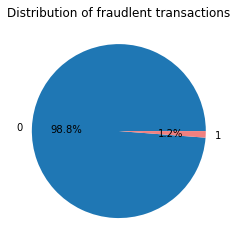

In [12]:
fraud_counts = banks['fraud'].value_counts()
fraud_percent = fraud_counts / fraud_counts.sum() * 100

print(f'Percent of fraudlent transactions: \n{fraud_percent}%.2f')

colors = ['tab:blue', 'lightcoral']
plt.pie(fraud_percent, labels=fraud_percent.index, colors=colors, autopct='%1.1f%%')
plt.title('Distribution of fraudlent transactions')
plt.show()

Also, there is a network graphs of data. Unfortunately, the NetworkX library does not provide enough power to plot them in the notebook. The graphs were plotted using graphistry library. Due to the high complexity, they were plotted on the subset of the data, which was randomly choosen from the data frame. Here are the results and plots of:

*Merchants by appearing in fraudlent transactions:*

The graph shows the connection between merchants and their appearance in fraud transaction. It is built using all the transactions from sample so that the ratio between fraud and non-fraud transaction would keep. By checking the link you can see an interactive map, which allows to check every edge (i. e. transaction) from dataset.

Link - https://hub.graphistry.com/graph/graph.html?dataset=9df4a0ae420340e483c1f16b1690a766&splashAfter=false&play=5000&session=922052c6dc0a427f8265ee117ee5a53a

*Merchants by selling in category:*

The following graph represent the connection between merchants and categories they sell in. We took only unique combination of seller-category, to make it easier to understand. The link also provides an ability to modify the graph, its vizualization, etc.

Link - https://hub.graphistry.com/graph/graph.html?dataset=86d21dded13b4afa9bce13cbe548e738

*Customers by buying in category:*

Finally, this graph represents the connection between customers and categories. The metodology was used as in the case of merchant-category graph, the link also provides more tools for graph setting.

Link - https://hub.graphistry.com/graph/graph.html?dataset=57bcd256e8f743f3b13fa59a66476c01

# Adding graph features to the data frame

In [3]:
# creating undirected graph
G = nx.from_pandas_edgelist(banks, 'customer', 'merchant', edge_attr='amount', create_using=nx.Graph())

# calculate features
pagerank = nx.pagerank(G)
degree = dict(G.degree())
partition = community_louvain.best_partition(G)

# convert to data frame
pagerank_df = pd.DataFrame(list(pagerank.items()), columns=['Node', 'PageRank'])
degree_df = pd.DataFrame(list(degree.items()), columns=['Node', 'Degree'])
partition_df = pd.DataFrame(list(partition.items()), columns=['Node', 'Community'])

# merge to customer
banks = pd.merge(banks, pagerank_df.add_prefix('Customer_'), how='left', left_on='customer', right_on='Customer_Node')
banks = pd.merge(banks, degree_df.add_prefix('Customer_'), how='left', left_on='customer', right_on='Customer_Node')
banks = pd.merge(banks, partition_df.add_prefix('Customer_'), how='left', left_on='customer', right_on='Customer_Node')

# merge to merchant
banks = pd.merge(banks, pagerank_df.add_prefix('Merchant_'), how='left', left_on='merchant', right_on='Merchant_Node')
banks = pd.merge(banks, degree_df.add_prefix('Merchant_'), how='left', left_on='merchant', right_on='Merchant_Node')
banks = pd.merge(banks, partition_df.add_prefix('Merchant_'), how='left', left_on='merchant', right_on='Merchant_Node')

banks.drop(columns=['Customer_Node', 'Merchant_Node'], inplace=True)

In [4]:
banks = banks[['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category', 'amount', 'fraud', 'Customer_PageRank', 'Customer_Degree', 'Customer_Community', 'Merchant_PageRank', 'Merchant_Degree', 'Merchant_Community']]
banks.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud,Customer_PageRank,Customer_Degree,Customer_Community,Merchant_PageRank,Merchant_Degree,Merchant_Community
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0,0.000094,7,0,0.038875,3929,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0,0.000136,12,0,0.038875,3929,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0,0.000152,14,2,0.035153,3573,1
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0,0.000128,11,1,0.038875,3929,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0,0.000152,14,0,0.038875,3929,0


In [3]:
banks = banks[['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category', 'amount', 'fraud']]
banks.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


# Preprocessing

As the data was made synthetically, there is already a good information which does not need to perform cleaning

In [5]:
banks.isna().sum()

step                  0
customer              0
age                   0
gender                0
zipcodeOri            0
merchant              0
zipMerchant           0
category              0
amount                0
fraud                 0
Customer_PageRank     0
Customer_Degree       0
Customer_Community    0
Merchant_PageRank     0
Merchant_Degree       0
Merchant_Community    0
dtype: int64

In [6]:
# scalling
columns_to_scale = ['Customer_PageRank', 'Customer_Degree', 'Customer_Community', 'Merchant_PageRank', 'Merchant_Degree', 'Merchant_Community']
standard_scaler = StandardScaler()
scaled_columns = standard_scaler.fit_transform(banks[columns_to_scale])
scaled_df = pd.DataFrame(scaled_columns, columns=columns_to_scale)

banks = pd.concat([banks[banks.columns.difference(columns_to_scale)], scaled_df], axis=1)

banks.head(5)

,age,amount,category,customer,fraud,gender,merchant,step,zipMerchant,zipcodeOri,Customer_PageRank,Customer_Degree,Customer_Community,Merchant_PageRank,Merchant_Degree,Merchant_Community
0,'4',4.55,'es_transportation','C1093826151',0,'M','M348934600',0,'28007','28007',-1.474832,-1.451389,-1.171316,0.642346,0.627143,-1.218323
1,'2',39.68,'es_transportation','C352968107',0,'M','M348934600',0,'28007','28007',0.221583,0.203358,-1.171316,0.642346,0.627143,-1.218323
2,'4',26.89,'es_transportation','C2054744914',0,'F','M1823072687',0,'28007','28007',0.862691,0.865257,1.775212,0.092221,0.102754,0.662213
3,'3',17.25,'es_transportation','C1760612790',0,'M','M348934600',0,'28007','28007',-0.109652,-0.127592,0.301948,0.642346,0.627143,-1.218323
4,'5',35.72,'es_transportation','C757503768',0,'M','M348934600',0,'28007','28007',0.868358,0.865257,-1.171316,0.642346,0.627143,-1.218323


In [4]:
# adding dummies for categorical values
dummy_df = banks.drop(['step', 'customer', 'zipcodeOri', 'zipMerchant'], axis=1)
dummy_df = pd.get_dummies(dummy_df, columns=['age', 'gender', 'category', 'merchant', 'Merchant_Community', 'Customer_Community'])

dummy_df.head(5)

KeyError: "['Merchant_Community', 'Customer_Community'] not in index"

In [5]:
#aa
dummy_df = banks.drop(['step', 'customer', 'zipcodeOri', 'zipMerchant'], axis=1)
dummy_df = pd.get_dummies(dummy_df, columns=['age', 'gender', 'category', 'merchant'])

dummy_df.head(5)

,amount,fraud,age_'0',age_'1',age_'2',age_'3',age_'4',age_'5',age_'6',age_'U',...,merchant_'M732195782',merchant_'M78078399',merchant_'M840466850',merchant_'M855959430',merchant_'M857378720',merchant_'M85975013',merchant_'M923029380',merchant_'M933210764',merchant_'M97925176',merchant_'M980657600'
0,4.55,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,39.68,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26.89,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17.25,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,35.72,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# adding dummies for rounded continious variables
columns = ['amount', 'Customer_PageRank', 'Merchant_PageRank', 'Customer_Degree', 'Merchant_Degree']

for column in columns:
    dummy_df[column] = dummy_df[column].round(0)
    dummies = pd.get_dummies(dummy_df[column], prefix=column)
    dummy_df = dummy_df.drop(columns=[column])
    dummy_df = pd.concat([dummy_df, dummies], axis=1)

In [6]:
#aa
columns = ['amount']

for column in columns:
    dummy_df[column] = dummy_df[column].round(0)
    dummies = pd.get_dummies(dummy_df[column], prefix=column)
    dummy_df = dummy_df.drop(columns=[column])
    dummy_df = pd.concat([dummy_df, dummies], axis=1)

# Creating model

Some models were trained on another computer, so they might not have an output. Also, the required computational power does not allow to run it on MacBook or Google Colab. That is why scores are written in the 1 line. Pkl model with the best model would be provided in the folder.

In [7]:
train, test = train_test_split(dummy_df)

X_train = train.drop('fraud', axis=1)
y_train = train['fraud']
X_test = test.drop('fraud', axis=1)
y_test = test['fraud']

In [ ]:
# Decision Tree / score: 0.84
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
print(f'Tree score: {roc_auc_score(y_test, tree_pred):.3f}')

# pkl_filename = '/content/gdrive/MyDrive/SNA/tree.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(tree, file)

Tree score: 0.838


In [8]:
# Logistic / score: 0.87
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
print(f'Logistic score: {roc_auc_score(y_test, logreg_pred):.3f}')

# pkl_filename = '/content/gdrive/MyDrive/SNA/logreg.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(logreg, file)

Logistic score: 0.846


In [ ]:
# Naive Bayes / score: 0.82
gauss = GaussianNB()
gauss.fit(X_train, y_train)
gauss_pred = gauss.predict(X_test)
print(f'Gauss score: {roc_auc_score(y_test, gauss_pred):.3f}')

# pkl_filename = 'gauss.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(gauss, file)

In [ ]:
# Gradient Boosting / score: 0.8
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
print(f'Gradient Boosting score: {roc_auc_score(y_test, gb_pred):.3f}')

# pkl_filename = '/content/gdrive/MyDrive/SNA/gb.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(gb, file)

In [ ]:
# Catboost / score: 0.84
cat = CatBoostClassifier()
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_test)
print(f'CatBoosting score: {roc_auc_score(y_test, cat_pred):.3f}')

# pkl_filename = '/content/gdrive/MyDrive/SNA/cat.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(cat, file)

Learning rate set to 0.139377
0:	learn: 0.3161855	total: 305ms	remaining: 5m 4s
1:	learn: 0.1621100	total: 646ms	remaining: 5m 22s
2:	learn: 0.0870690	total: 981ms	remaining: 5m 26s
3:	learn: 0.0542823	total: 1.32s	remaining: 5m 27s
4:	learn: 0.0386625	total: 1.56s	remaining: 5m 11s
5:	learn: 0.0349443	total: 1.72s	remaining: 4m 44s
6:	learn: 0.0292023	total: 1.83s	remaining: 4m 20s
7:	learn: 0.0258757	total: 2s	remaining: 4m 8s
8:	learn: 0.0246447	total: 2.14s	remaining: 3m 55s
9:	learn: 0.0237511	total: 2.33s	remaining: 3m 50s
10:	learn: 0.0218365	total: 2.5s	remaining: 3m 44s
11:	learn: 0.0210882	total: 2.79s	remaining: 3m 49s
12:	learn: 0.0200808	total: 3.04s	remaining: 3m 51s
13:	learn: 0.0186626	total: 3.3s	remaining: 3m 52s
14:	learn: 0.0183958	total: 3.54s	remaining: 3m 52s
15:	learn: 0.0181338	total: 3.79s	remaining: 3m 53s
16:	learn: 0.0179515	total: 4s	remaining: 3m 51s
17:	learn: 0.0177668	total: 4.19s	remaining: 3m 48s
18:	learn: 0.0176485	total: 4.41s	remaining: 3m 47s
19

In [ ]:
# Random Forest / score: 0.81
ranf = RandomForestClassifier()
ranf.fit(X_train, y_train)
ranf_pred = ranf.predict  (X_test)
print(f'CatBoosting score: {roc_auc_score(y_test, ranf_pred):.3f}')

# pkl_filename = '/content/gdrive/MyDrive/SNA/ranf.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(ranf, file)

CatBoosting score: 0.812


As can be seen, the best model by performance is Logistic Regression with score = 0.87. Here is the matrix with metrics for it:

In [30]:
print(classification_report(y_test, logreg_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    146860
           1       0.86      0.74      0.79      1801

    accuracy                           1.00    148661
   macro avg       0.93      0.87      0.89    148661
weighted avg       1.00      1.00      1.00    148661



We can see, that precision and recall for 1 is 0.86 and 0.74. For our task, recall is more important, as the problem is to detect the fraudlent transaction for futher analysis, so getting all true fraudlent and some false fraudlent is better then getting no false fraudlent but not all.

In [24]:
# Load best model to have the predictions

# pkl_filename = 'logreg.pkl'
# with open(pkl_filename, 'rb') as file:
#   logreg = pickle.load(file)

# logreg_pred = logreg.predict(X_test)
# print(f'Logreg score: {roc_auc_score(y_test, logreg_pred):.3f}')

# Adding SMOTE

The problem with that task is that the dataset is biased. We already checked that there are 98% of non-fraud agents. So, technically, model will be very biased to 0 and can ignore 1 in making the decision. The way to do it is to resample the dataset using SMOTE and TomekLinks. They prevent oversampling and undersampling of the data to improve the model quality.

In [13]:
smote_X_train, smote_y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

In [14]:
# Logistic Smote
logreg_smote = LogisticRegression()
logreg_smote.fit(smote_X_train, smote_y_train)
logreg_smote_pred = logreg_smote.predict(X_test)
print(f'Logistic_smote score: {roc_auc_score(y_test, logreg_smote_pred):.3f}')

# pkl_filename = '/content/gdrive/MyDrive/SNA/logreg_smote.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(logreg_smote, file)

Logistic_smote score: 0.858


Here can be seen, that the ROC AUC score is worse, than without smote. This can be due to the fact, that network features and high amount of dummies already prevented overfitting and bias of the model.

In [26]:
print(classification_report(y_test, logreg_smote_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    146876
           1       0.76      0.72      0.74      1785

    accuracy                           0.99    148661
   macro avg       0.88      0.86      0.87    148661
weighted avg       0.99      0.99      0.99    148661



As can be seen, the recall also did not change, so smote made no increase to performance

# Custom Logistic Regression

In real world, Logistic Regression mostly not used out of the box. That is why companies write them from scratch, so here is a try to implement the Logistic Regression logic from scratch.

In [31]:
class CustomLogisticRegression:
    def __init__(self, penalty='l2', tol=1e-4, C=1.0, fit_intercept=True,
                 intercept_scaling=1, class_weight=None, random_state=None,
                 solver='lbfgs', max_iter=100, warm_start=False, n_jobs=None,
                 l1_ratio=None, learning_rate=0.1):
        self.penalty = penalty
        self.tol = tol
        self.C = C
        self.fit_intercept = fit_intercept
        self.intercept_scaling = intercept_scaling
        self.class_weight = class_weight
        self.random_state = random_state
        self.solver = solver
        self.max_iter = max_iter
        self.warm_start = warm_start
        self.n_jobs = n_jobs
        self.l1_ratio = l1_ratio
        self.learning_rate = learning_rate

    def add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.hstack((intercept, X))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def cost_function(self, w, X, y):
        m = len(y)
        h = self.sigmoid(np.dot(X, w))
        if self.penalty == 'l1':
            reg_term = self.C * np.sum(np.abs(w))
        elif self.penalty == 'l2':
            reg_term = 0.5 * self.C * np.sum(w**2)
        elif self.penalty == 'elasticnet':
            reg_term = self.C * (self.l1_ratio * np.sum(np.abs(w)) + 0.5 * (1 - self.l1_ratio) * np.sum(w**2))
        else:  # none
            reg_term = 0
        cost = -np.sum(y * np.log(h) + (1 - y) * np.log(1 - h)) / m + reg_term
        return cost

    def gradient(self, w, X, y):
        m = len(y)
        h = self.sigmoid(np.dot(X, w))
        gradient = np.dot(X.T, (h - y)) / m

        if self.penalty == 'l1':
            reg_term = self.C * np.sign(w)
        elif self.penalty == 'l2':
            reg_term = self.C * w
        elif self.penalty == 'elasticnet':
            reg_term = self.C * (self.l1_ratio * np.sign(w) + (1 - self.l1_ratio) * w)
        else:  # none
            reg_term = 0
        return gradient + reg_term
    
    
    def hessian(self, w, X, y):
        h = self.sigmoid(np.dot(X, w))
        hessian = np.dot(((h * (1 - h)).reshape(-1, 1) * X).T, X)

        if self.penalty == 'l1':
            reg_term = self.C * np.diag(np.sign(w))
        elif self.penalty == 'l2':
            reg_term = self.C * np.diag(w)
        elif self.penalty == 'elasticnet':
            reg_term = self.C * np.diag(self.l1_ratio * np.sign(w) + (1 - self.l1_ratio) * w)
        else:  # none
            reg_term = 0
        return hessian + reg_term
    
    
    def newton_cg(self, X, y, w):
        for _ in range(self.max_iter):
            gradient = self.gradient(w, X, y)
            hessian = self.hessian(w, X, y)
            hessian += np.eye(hessian.shape[0]) * 1e-5  # Regularization term
            step_direction = np.linalg.solve(hessian, gradient)
            w -= self.learning_rate * step_direction
        return w

    
    @staticmethod
    def cholesky_decomposition(A):
        n = A.shape[0]
        L = np.zeros_like(A)
        for i in range(n):
            for j in range(i+1):
                s = np.sum(L[i, :j] * L[j, :j])
                if i == j:
                    L[i, j] = np.sqrt(A[i, i] - s)
                else:
                    L[i, j] = (A[i, j] - s) / L[j, j]
        return L

    @staticmethod
    def forward_substitution(L, b):
        n = L.shape[0]
        y = np.zeros_like(b)
        for i in range(n):
            y[i] = (b[i] - np.sum(L[i, :i] * y[:i])) / L[i, i]
        return y

    @staticmethod
    def backward_substitution(U, y):
        n = U.shape[0]
        x = np.zeros_like(y)
        for i in range(n-1, -1, -1):
            x[i] = (y[i] - np.sum(U[i, i+1:] * x[i+1:])) / U[i, i]
        return x

    @staticmethod
    def vector_norm(x):
        return np.sqrt(np.sum(x**2))


    def newton_cholesky(self, X, y, w_init):
        w = w_init.copy()
        for _ in range(self.max_iter):
            gradient = self.gradient(w, X, y)
            hessian = self.hessian(w, X, y)
            hessian += np.eye(hessian.shape[0]) * 1e-5  # Regularization term
            try:
                L = CustomLogisticRegression.cholesky_decomposition(hessian)
                y_vec = CustomLogisticRegression.forward_substitution(L, gradient)
                step_direction = CustomLogisticRegression.backward_substitution(L.T, y_vec)
            except ValueError:
                step_direction = np.linalg.solve(hessian, gradient)
            w -= self.learning_rate * step_direction
            if CustomLogisticRegression.vector_norm(gradient) < self.tol:
                break
        return w

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.add_intercept(X)
        w_init = np.zeros(X.shape[1])

        if self.solver == 'newton-cg':
            self.w_ = self.newton_cg(X, y, w_init)
        elif self.solver == 'newton-cholesky':
            self.w_ = self.newton_cholesky(X, y, w_init)
        else:
            raise ValueError(
                f"Solver '{self.solver}' not supported. Use 'newton-cg', 'newton-cholesky'"
            )


    def predict_proba(self, X):
        if self.fit_intercept:
            X = self.add_intercept(X)
        return self.sigmoid(np.dot(X, self.w_))


    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

In [32]:
logreg_custom = CustomLogisticRegression(solver='newton-cg')
logreg_custom.fit(X_train, y_train)
logreg_custom_pred = logreg_custom.predict(X_test)
print(f'Custom LogReg score: {roc_auc_score(y_test, logreg_custom_pred):.3f}')

Unfortunately, the training was performed on another computer and results does not show up in the notebook, but custom logistic regression ended up giving score of about 0.83 and recall of 0.71, so there is a no improvement in using custom class.

# Results

Overall, addition of network features was a good choice. Firstly, it solved the problem of unbalanced data without need for resampling. Secondly, the top performance of auc of 0.87 
and recall of 0.74 is not so bad result, which means that 74% of actual fraud transactions are being pointed on for further analysis.